In [10]:
import torch
import os
import json
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders
from sklearn.metrics import roc_auc_score, roc_curve
import sys

sys.path.insert(0, '..')

## Create the dataset class

In [19]:
class NetworkDatasetDetection(torch.utils.data.Dataset):
    def __init__(self, model_folder):
        super().__init__()
        model_paths = []
        model_paths.extend([os.path.join(model_folder, 'clean', x) \
                            for x in sorted(os.listdir(os.path.join(model_folder, 'clean')))])
        model_paths.extend([os.path.join(model_folder, 'trojan', x) \
                            for x in sorted(os.listdir(os.path.join(model_folder, 'trojan')))])
        labels = []
        data_sources = []
        for p in model_paths:
            with open(os.path.join(p, 'info.json'), 'r') as f:
                info = json.load(f)
                data_sources.append(info['dataset'])
            if p.split('/')[-2] == 'clean':
                labels.append(0)
            elif p.split('/')[-2] == 'trojan':
                labels.append(1)
            else:
                raise ValueError('unexpected path {}'.format(p))
        self.model_paths = model_paths
        self.labels = labels
        self.data_sources = data_sources
    
    def __len__(self):
        return len(self.model_paths)
    
    def __getitem__(self, index):
        return torch.load(os.path.join(self.model_paths[index], 'model.pt')), \
               self.labels[index], self.data_sources[index]

def custom_collate(batch):
    return [x[0] for x in batch], [x[1] for x in batch], [x[2] for x in batch]

In [20]:
!pwd

/Users/fhasan8/study/tdc22/tdc-starter-kit/detection


## Load data
Spliting off a validation set from the train set for testing purposes.

In [22]:
dataset_path = '../../tdc_datasets'
task = 'detection'
dataset = NetworkDatasetDetection(os.path.join(dataset_path, task, 'train'))
seed = 42
np.random.seed(seed)

split = int(len(dataset) * 0.8)
rnd_idx = np.random.permutation(len(dataset))
train_dataset = torch.utils.data.Subset(dataset, rnd_idx[:split])
val_dataset = torch.utils.data.Subset(dataset, rnd_idx[split:])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True,
                                           num_workers=0, pin_memory=False, collate_fn=custom_collate)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                           num_workers=0, pin_memory=False, collate_fn=custom_collate)

## Construct the MNTD network

In [23]:

data_sources = ['CIFAR-10', 'CIFAR-100', 'GTSRB', 'MNIST']
data_source_to_channel = {k: 1 if k == 'MNIST' else 3 for k in data_sources}
data_source_to_resolution = {k: 28 if k == 'MNIST' else 32 for k in data_sources}
data_source_to_num_classes = {'CIFAR-10': 10, 'CIFAR-100': 100, 'GTSRB': 43, 'MNIST': 10}

class MetaNetwork(nn.Module):
    def __init__(self, num_queries, num_classes=1):
        super().__init__()
        self.queries = nn.ParameterDict(
            {k: nn.Parameter(torch.rand(num_queries,
                                        data_source_to_channel[k],
                                        data_source_to_resolution[k],
                                        data_source_to_resolution[k])) for k in data_sources}
        )
        self.affines = nn.ModuleDict(
            {k: nn.Linear(data_source_to_num_classes[k]*num_queries, 32) for k in data_sources}
        )
        self.norm = nn.LayerNorm(32)
        self.relu = nn.ReLU(True)
        self.final_output = nn.Linear(32, num_classes)
    
    def forward(self, net, data_source):
        """
        :param net: an input network of one of the model_types specified at init
        :param data_source: the name of the data source
        :returns: a score for whether the network is a Trojan or not
        """
        query = self.queries[data_source]
        out = net(query)
        out = self.affines[data_source](out.view(1, -1))
        out = self.norm(out)
        out = self.relu(out)
        return self.final_output(out)

In [ ]:
## Network in linear layers
class MetaNetwork(nn.Module):
    def __init__(self, num_queries, num_classes=1):
        super().__init__()
        self.queries = nn.ParameterDict(
            {k: nn.Parameter(torch.rand(num_queries,
                                        data_source_to_channel[k],
                                        data_source_to_resolution[k],
                                        data_source_to_resolution[k])) for k in data_sources}
        )
        self.affines = nn.ModuleDict(
            {k: nn.Linear(data_source_to_num_classes[k]*num_queries, 1024) for k in data_sources}
        )
        self.norm = nn.LayerNorm(1024)
        self.relu = nn.ReLU(True)
        self.final_output1 = nn.Linear(1024, 32)
        self.final_output2 = nn.Linear(32, num_classes)
    
    def forward(self, net, data_source):
        """
        :param net: an input network of one of the model_types specified at init
        :param data_source: the name of the data source
        :returns: a score for whether the network is a Trojan or not
        """
        query = self.queries[data_source]
        out = net(query)
        out = self.affines[data_source](out.view(1, -1))
        out = self.norm(out)
        out = self.relu(out)
        out = self.final_output1(out)
        return self.final_output2(out)

In [49]:
## Deep network with linear layers
class MetaNetworkLinear(nn.Module):
    def __init__(self, num_queries, num_classes=1):
        super().__init__()
        self.queries = nn.ParameterDict(
            {k: nn.Parameter(torch.rand(num_queries,
                                        data_source_to_channel[k],
                                        data_source_to_resolution[k],
                                        data_source_to_resolution[k])) for k in data_sources}
        )
        self.affines = nn.ModuleDict(
            {k: nn.Linear(data_source_to_num_classes[k]*num_queries, 4096) for k in data_sources}
        )
        self.norm = nn.LayerNorm(4096)
        self.relu = nn.ReLU(True)
        self.affines1 = nn.ModuleDict(
            {k: nn.Linear(4096, 512) for k in data_sources}
        )
        self.norm1 = nn.LayerNorm(512)
        self.relu1 = nn.ReLU(True)
        self.affines2 = nn.ModuleDict(
            {k: nn.Linear(512, 32) for k in data_sources}
        )
        self.norm2 = nn.LayerNorm(32)
        self.relu2 = nn.ReLU(True)
        self.final_output2 = nn.Linear(32, num_classes)
        
    
    def forward(self, net, data_source):
        """
        :param net: an input network of one of the model_types specified at init
        :param data_source: the name of the data source
        :returns: a score for whether the network is a Trojan or not
        """
        query = self.queries[data_source]
        out = net(query)
        out = self.affines[data_source](out.view(1, -1))
        out = self.norm(out)
        out = self.relu(out)
        out = self.affines1[data_source](out)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.affines[data_source](out)
        out = self.norm(out)
        out = self.relu(out)
        return self.final_output2(out)

In [36]:
## Deep network with convolution layers
class MetaNetworkDeepConvolution(nn.Module):
    def __init__(self, num_queries, num_classes=1):
        super().__init__()
        self.queries = nn.ParameterDict(
            {k: nn.Parameter(torch.rand(num_queries,
                                        data_source_to_channel[k],
                                        data_source_to_resolution[k],
                                        data_source_to_resolution[k])) for k in data_sources}
        )
        self.affines = nn.ModuleDict(
            {k: nn.Linear(data_source_to_num_classes[k]*num_queries, 4096) for k in data_sources}
        )
        self.norm = nn.LayerNorm(4096)
        self.relu = nn.ReLU(True)
        self.conv1 = nn.Conv2d(4096, 1024, kernel_size = 3, padding='same')
        self.maxpool1 = nn.MaxPool2d(3)
        self.norm2 = nn.BatchNorm2d(1024)
        self.final_output2 = nn.Linear(32, num_classes)
        
    
    def forward(self, net, data_source):
        """
        :param net: an input network of one of the model_types specified at init
        :param data_source: the name of the data source
        :returns: a score for whether the network is a Trojan or not
        """
        query = self.queries[data_source]
        out = net(query)
        out = self.affines[data_source](out.view(1, -1))
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.maxpool1(out)
        return self.final_output2(out)

## Train the network

In [50]:
meta_network = MetaNetwork(30, num_classes=1).train()

num_epochs = 10
lr = 0.01
weight_decay = 1e-7
optimizer = torch.optim.Adam(meta_network.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs * len(train_dataset))

loss_ema = np.inf
for epoch in range(num_epochs):
    
    pbar = tqdm(train_loader)
    pbar.set_description(f"Epoch {epoch + 1}")
    for i, (net, label, data_source) in enumerate(pbar):
        net = net[0]
        label = label[0]
        data_source = data_source[0]
        net.eval()
        
        out = meta_network(net, data_source)
        loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label]).unsqueeze(0))
        
        optimizer.zero_grad()
        loss.backward(inputs=list(meta_network.parameters()))
        optimizer.step()
        scheduler.step()
        for k in meta_network.queries.keys():
            meta_network.queries[k].data = meta_network.queries[k].data.clamp(0, 1)
        loss_ema = loss.item() if loss_ema == np.inf else 0.95 * loss_ema + 0.05 * loss.item()

        pbar.set_postfix(loss=loss_ema)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

## Evaluate the network

In [86]:
def evaluate(meta_network, loader):
    loss_list = []
    correct_list = []
    confusion_matrix = torch.zeros(2,2)
    all_scores = []
    all_labels = []
    data_sources = []
    
    for i, (net, label, data_source) in enumerate(tqdm(loader)):
        net[0].eval()
        with torch.no_grad():
            out = meta_network(net[0], data_source[0])
        loss = F.binary_cross_entropy_with_logits(out, torch.FloatTensor([label[0]]).unsqueeze(0))
        correct = int((out.squeeze() > 0).int().item() == label[0])
        loss_list.append(loss.item())
        correct_list.append(correct)
        confusion_matrix[(out.squeeze() > 0).int().item(), label[0]] += 1
        all_scores.append(out.squeeze().item())
        all_labels.append(label[0])
        data_sources.append(data_source)
    
    return np.mean(loss_list), np.mean(correct_list), confusion_matrix, all_labels, all_scores, data_sources

In [52]:
loss, acc, cmat, _, _, _ = evaluate(meta_network, train_loader)
print(f'Train Loss: {loss:.3f}, Train Accuracy: {acc*100:.2f}')
print('Confusion Matrix:\n', cmat.numpy())

  0%|          | 0/800 [00:00<?, ?it/s]

Train Loss: 0.031, Train Accuracy: 99.25
Confusion Matrix:
 [[399.   6.]
 [  0. 395.]]


In [87]:
loss, acc, cmat, all_labels, all_preds, data_sources = evaluate(meta_network, val_loader)
print(f'Val Loss: {loss:.3f}, Val Accuracy: {acc*100:.2f}')
print('Confusion Matrix:\n', cmat.numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

Val Loss: 1.961, Val Accuracy: 63.50
Confusion Matrix:
 [[65. 37.]
 [36. 62.]]


In [88]:
print(f'Val AUROC: {roc_auc_score(all_labels, all_preds):.3f}')


Val AUROC: 0.702


In [57]:
path = os.path.join("./", "model.pt")
torch.save(meta_network.state_dict(), path)

# Analysis

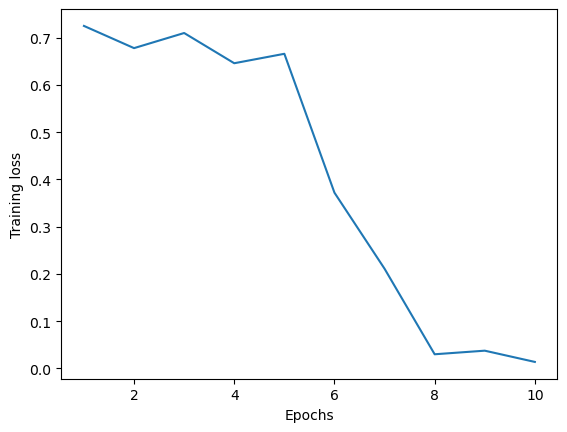

In [77]:
loss = [0.725, 0.678, 0.71, 0.646, 0.666, 0.372,  0.211, 0.0299, 0.0375, 0.0137]
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(epochs, loss)
plt.ylabel('Training loss')
plt.xlabel('Epochs')
plt.show()

In [89]:
preds = ((np.array(all_preds)>0).astype(int))
labels = ["clean", "trojaned"]

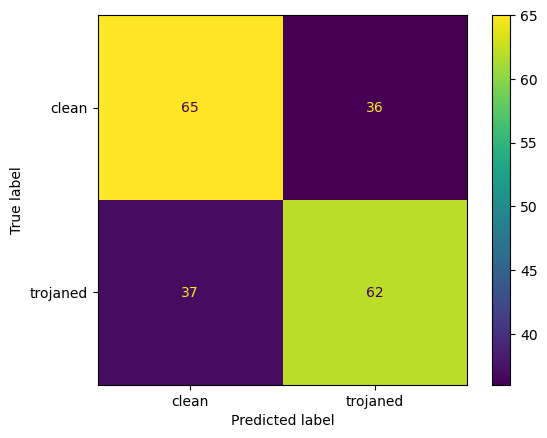

In [85]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.show()

In [117]:
p = np.array(preds)
l = np.array(all_labels)
d = np.array(data_sources)
d[np.where(p==l)].shape

print((d[np.where(p==l)]=='CIFAR-10').sum())
print((d=='CIFAR-10').sum())
print((d[np.where(p==l)]=='MNIST').sum())
print((d=='MNIST').sum())
print((d[np.where(p==l)]=='CIFAR-100').sum())
print((d=='CIFAR-100').sum())
print((d[np.where(p==l)]=='GTSRB').sum())
print((d=='GTSRB').sum())



40
53
24
47
38
52
25
48


In [102]:
40/53

0.7547169811320755

In [103]:
24/47

0.5106382978723404

In [104]:
38/52

0.7307692307692307

In [105]:
25/48

0.5208333333333334

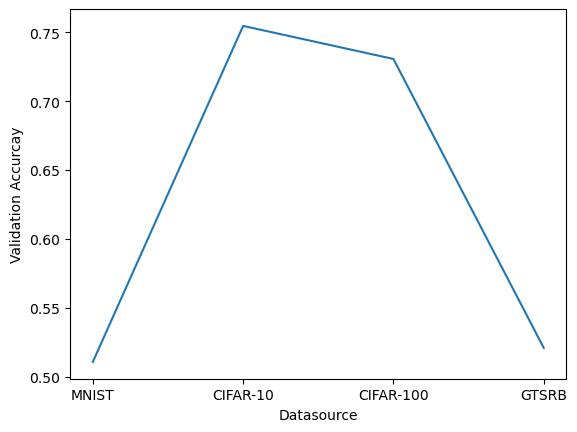

In [120]:
loss = [0.5106, 0.7547, 0.7307, 0.5208]
epochs = ['MNIST','CIFAR-10', 'CIFAR-100', 'GTSRB']
plt.plot(epochs, loss)
plt.ylabel('Validation Accurcay')
plt.xlabel('Datasource')
plt.show()

In [133]:
p = np.array(preds)
l = np.array(all_labels)
d = np.array(data_sources)
d[np.where(p==l)].shape
cf10= (np.where(d=='CIFAR-10'))[0]
l1 = np.where(l==1)[0]
l1count = 0
for i in cf10:
    if i in l1:
        l1count +=1
print(l1count)
print(53-l1count)
cf10= (np.where(d=='MNIST'))[0]
l1 = np.where(l==1)[0]
l1count = 0
for i in cf10:
    if i in l1:
        l1count +=1
print(l1count)
print(47-l1count)
cf10= (np.where(d=='CIFAR-100'))[0]
l1 = np.where(l==1)[0]
l1count = 0
for i in cf10:
    if i in l1:
        l1count +=1
print(l1count)
print(52-l1count)
cf10= (np.where(d=='GTSRB'))[0]
l1 = np.where(l==1)[0]
l1count = 0
for i in cf10:
    if i in l1:
        l1count +=1
print(l1count)
print(48-l1count)


25
28
17
30
27
25
30
18
